In [173]:
import gzip
import math
import numpy
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
from gensim.models import Word2Vec
import dateutil
from scipy.sparse import lil_matrix # To build sparse feature matrices, if you like
import pandas as pd

import html
import random
import json

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

This takes a 1.5 mins to run

In [3]:
# allRatings = [l for l in parse("ratebeer.json.gz")]
rawRatings = [l for l in parse("sampled_ratebeer.json.gz")][0] # sampled has 300,000 reviews

# Sample and compress dataset (ALREADY RAN DONT RUN)

In [ ]:
# # Random sample the dataset because it's too big

# sampleSize = 300000
# sampledAllRatings = random.sample(ratings, sampleSize)

In [ ]:
# import json

# with open("sampled_ratebeer.json", "w") as f:
#     json.dump(sampledAllRatings, f)

In [ ]:
# import gzip
# import shutil

# # File paths
# input_file = 'sampled_ratebeer.json'      # Your existing JSON file
# output_file = 'sampled_ratebeer.json.gz'  # Desired compressed file

# # Compress the JSON file
# with open(input_file, 'rb') as f_in:
#     with gzip.open(output_file, 'wb') as f_out:
#         shutil.copyfileobj(f_in, f_out)

# print(f"Compressed {input_file} to {output_file}")


Compressed sampled_ratebeer.json to sampled_ratebeer.json.gz


# Clean data

Check missing labels (beer/style)

In [4]:
# Removing escape sequences from labels
for rating in rawRatings:
    if 'beer/style' in rating:
        rating['beer/style'] = html.unescape(rating['beer/style'])

In [5]:
styles = set()
no_style = []

for rating in rawRatings:
    if 'beer/style' in rating:
        styles.add(rating['beer/style'])
    else:
        no_style.append(rating)

len(styles), len(no_style)

(89, 0)

Check missing features

In [165]:
import json

with open('beer_mapping.json') as f:
    beerFlavorMapping = json.load(f)

def findFlavor(style: str) -> str:
    for flavor in beerFlavorMapping:
        if style in beerFlavorMapping[flavor]:
            return flavor

beerFlavorMapping.keys()

dict_keys(['malty', 'hoppy', 'crisp', 'roasty', 'fruity/spicy', 'sour', 'rich/hearty', 'smoky', 'specialty'])

In [141]:
def checkMissingFeatures(rating):
    return (
        rating['beer/name'] == "" or 
        rating['beer/ABV'] == "" or rating['beer/ABV'] == "-" or  # the - case is for some reason in our data
        rating['review/text'] == ""
    )
    
cleanedRatings = []

for rating in rawRatings:
    if not checkMissingFeatures(rating):
        rating['beer/flavor'] = findFlavor(rating['beer/style'])
        cleanedRatings.append(rating)

# Do some analysis on our data
Ideas
- Statistics on length of review/text
- Statistics by flavor

In [169]:
reviewLens = []

for rating in cleanedRatings:
    reviewLens.append(len(rating['review/text']))

In [170]:
import numpy as np

def getStats(data: list[int]) -> tuple:
    dataMin = min(data)
    dataMax = max(data)
    dataMean = np.mean(data)
    dataMedian = np.median(data)
    dataSTD = np.std(data)
    
    return dataMin, dataMax, dataMean, dataMedian, dataSTD

In [171]:
reviewLenMin, reviewLenMax, reviewLenMean, reviewLenMedian, reviewLenSTD = getStats(reviewLens)
print(f'Min: {reviewLenMin}, Max: {reviewLenMax}, Mean: {reviewLenMean}, Median: {reviewLenMedian}, STD: {reviewLenSTD}')

Min: 3, Max: 8605, Mean: 308.61420332030224, Median: 254.0, STD: 215.79764210262408


In [148]:
beerDF = pd.DataFrame(cleanedRatings)

Identify the counts for each style of beer

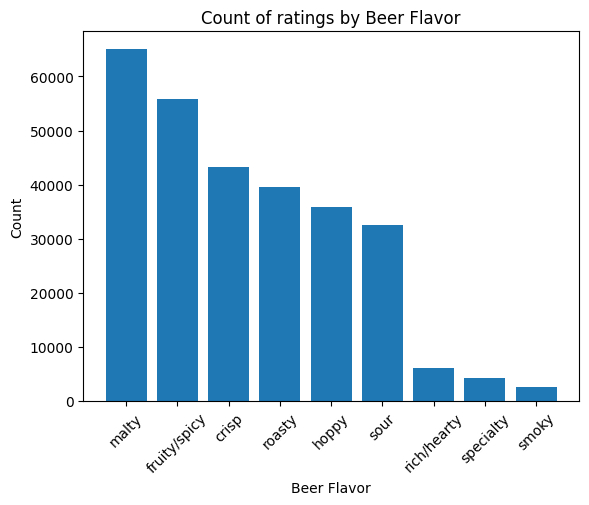

In [179]:
graph = plt.bar(beerDF['beer/flavor'].unique(), beerDF['beer/flavor'].value_counts())
plt.title('Count of ratings by Beer Flavor')
plt.xlabel('Beer Flavor')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [184]:
def removeOutlierFromDF(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    df['beer/ABV'] = df[feature].apply(float)

    # Clean the outliers out
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    noOutlierDF = df[(lower <= df[feature]) & (df[feature] <= upper)]
    return noOutlierDF

In [180]:
def plotBarByFlavor(df: pd.DataFrame, y: str, title=''):
    sns.boxplot(data=df, x='beer/flavor', y=y)
    plt.title(title)
    plt.xlabel('Beer Flavor')
    plt.ylabel(y)
    plt.xticks(rotation=45)
    plt.show()

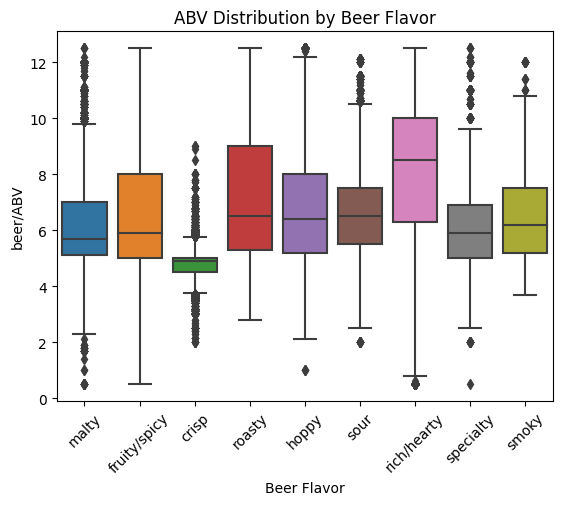

In [186]:
noOutlierABVDF = removeOutlierFromDF(beerDF, 'beer/ABV')
plotBarByFlavor(noOutlierABVDF, 'beer/ABV', 'ABV Distribution by Beer Flavor')

In [187]:
beerDF['review/text length'] = beerDF['review/text'].apply(len)
noOutlierLengthDF = removeOutlierFromDF(beerDF, 'review/text length')

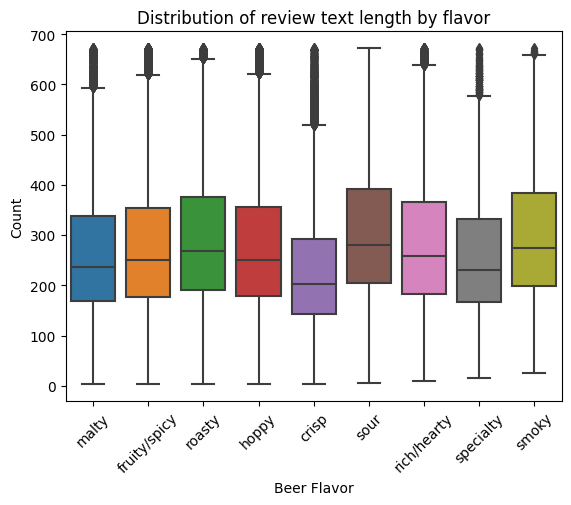

In [ ]:
sns.boxplot(data=noOutlierLengthDF, x='beer/flavor', y='review/text length')
plotBarByFlavor(noOutlierABVDF, 'review/text length', 'Distribution of Review Text Length by Beer flavor')
plt.title('Distribution of review text length by flavor')
plt.xlabel('Beer Flavor')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Get features
We get only the features we want to use ('beer/name', 'review/text')

In [ ]:
# Only contains features we will use
filteredRatings = []

for rating in cleanedRatings:
    featureDict = {
        'beer/name': rating['beer/name'],
        'review/text': rating['review/text'],
        'beer/style': rating['beer/style'],
        'beer/flavor': rating['beer/flavor']
    }
    
    filteredRatings.append(featureDict)

## Prepare the features
- Remove escape characters from `review/text`

In [ ]:
# https://stackoverflow.com/questions/8115261/how-to-remove-all-the-escape-sequences-from-a-list-of-strings
escapeChars = ''.join([chr(char) for char in range(1, 32)])
translator = str.maketrans('', '', escapeChars)

# Remove escape characters from `review/text`
def removeEscapeChars(review: str) -> str:
    return review.translate(translator)

for rating in filteredRatings: 
    rating['review/text'] = removeEscapeChars(rating['review/text'])

# Split dataset

In [82]:
splitIndex = int(len(filteredRatings) * 0.95)
ratingsTrain = filteredRatings[:splitIndex]
ratingsTest = filteredRatings[splitIndex:]

len(ratingsTrain), len(ratingsTest)

(270954, 14261)

# Feature encoding

# Feature engineering for flavor labels

The `beer_mapping.json` file contains mappings for beer types to flavor labels generated by ChatGPT to group beers into flavors. A beer can be in multiple flavors.

In [ ]:
import json

with open('beer_mapping.json') as f:
    beerFlavorMapping = json.load(f)

beerFlavorMapping.keys()

dict_keys(['crisp', 'malty', 'hoppy', 'roasty', 'fruity/spicy', 'sour', 'smoky', 'specialty', 'rich/hearty'])